In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
import os
import json
from pandas.io.json import json_normalize

In [ ]:
This time we were given a small set of data and therefore the entire data was loaded into the dataframe.

In [2]:
train_data = pd.read_csv("C:/Users/Shreya Majumder/Desktop/Fall Sem/DSF/all/train.csv")

C:\Users\Shreya Majumder\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test_data = pd.read_csv("C:/Users/Shreya Majumder/Desktop/Fall Sem/DSF/all/test.csv")

C:\Users\Shreya Majumder\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
There were few JSON columns in the dataset which had to be extracted.

In [4]:
def load_df(csv_path='C:/Users/Shreya Majumder/Desktop/Fall Sem/DSF/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("C:/Users/Shreya Majumder/Desktop/Fall Sem/DSF/all/"))

['new_test.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [5]:
def load_df1(csv_path='C:/Users/Shreya Majumder/Desktop/Fall Sem/DSF/all/test.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("C:/Users/Shreya Majumder/Desktop/Fall Sem/DSF/all/"))

['new_test.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [6]:
train_df = load_df()

Loaded train.csv. Shape: (903653, 55)


In [7]:
test_df = load_df1()

Loaded test.csv. Shape: (804684, 53)


In [ ]:
Data Cleaning : After extracting there were a lot of columns(55 to be exact) and most of the 
    columns contained Nan values. So I ran a query to check those columns

In [9]:
%%time
cdf = pd.concat([train_df.count(), train_df.nunique(), train_df.isna().sum(), train_df.dtypes], axis = 1)
cdf = cdf.reset_index()
cdf.columns = ["Column_Name", "Total_Records", "Unique_Values", "Null Values", "data_types"]

Wall time: 1min 32s


In [10]:
cdf[cdf.Total_Records > 0].reset_index()

,index,Column_Name,Total_Records,Unique_Values,Null Values,data_types
0,0,channelGrouping,903653,8,0,object
1,1,date,903653,366,0,int64
2,2,fullVisitorId,903653,714167,0,object
3,3,sessionId,903653,902755,0,object
4,4,socialEngagementType,903653,1,0,object
5,5,visitId,903653,886303,0,int64
6,6,visitNumber,903653,384,0,int64
7,7,visitStartTime,903653,887159,0,int64
8,8,device.browser,903653,54,0,object
9,9,device.browserSize,903653,1,0,object


In [ ]:
I wrote a Query to remove the columns where all the values were null or which had just one 
   unique value of no importance.

In [8]:
null_count=((train_df[train_df.columns] == 'not available in demo dataset') | (train_df[train_df.columns].isna())).sum()

In [9]:
null_count1=((test_df[test_df.columns] == 'not available in demo dataset') | (test_df[test_df.columns].isna())).sum()

In [10]:
keys = null_count.keys()

In [11]:
keys1 = null_count1.keys()

In [12]:
df_size=len(train_df)

In [13]:
df_size1=len(test_df)

In [14]:
null_col = [col for col in keys if null_count[str(col)] > 0 if null_count[str(col)] == df_size]

In [15]:
null_col1 = [col for col in keys1 if null_count1[str(col)] > 0 if null_count1[str(col)] == df_size1]

In [16]:
train_df.drop(columns=null_col,inplace=True)

In [17]:
test_df.drop(columns=null_col1,inplace=True)

In [18]:
train_df.drop(columns=['socialEngagementType'], inplace=True)

In [19]:
test_df.drop(columns=['socialEngagementType'], inplace=True)

In [20]:
train_df.drop(columns=['trafficSource.campaignCode'], inplace=True)

In [ ]:
This query was again run to check whether all the cleaning has been done of not so important columns.

In [24]:
cdf1 = pd.concat([train_df.count(), train_df.nunique(), train_df.isna().sum(), train_df.dtypes], axis = 1)
cdf1 = cdf1.reset_index()
cdf1.columns = ["Column_Name", "Total_Records", "Unique_Values", "Null Values", "data_types"]

In [25]:
cdf1[cdf1.Total_Records > 0].reset_index()

,index,Column_Name,Total_Records,Unique_Values,Null Values,data_types
0,0,channelGrouping,903653,8,0,object
1,1,date,903653,366,0,int64
2,2,fullVisitorId,903653,714167,0,object
3,3,sessionId,903653,902755,0,object
4,4,visitId,903653,886303,0,int64
5,5,visitNumber,903653,384,0,int64
6,6,visitStartTime,903653,887159,0,int64
7,7,device.browser,903653,54,0,object
8,8,device.deviceCategory,903653,3,0,object
9,9,device.isMobile,903653,2,0,bool


In [ ]:
As a part of Data Cleaning, I imputed the Nan values of few columns so that my prediction turns out 
 be as close to correct.

In [21]:
train_df['totals.newVisits'].fillna(0,inplace=True)
train_df['totals.pageviews'].fillna(0,inplace=True)
train_df['totals.hits'].fillna(0,inplace=True)
train_df['trafficSource.adwordsClickInfo.page'].fillna(0,inplace=True)
train_df['totals.bounces'].fillna(0,inplace=True)
train_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [22]:
test_df['totals.newVisits'].fillna(0,inplace=True)
test_df['totals.pageviews'].fillna(0,inplace=True)
test_df['totals.bounces'].fillna(0,inplace=True)
test_df['totals.hits'].fillna(0,inplace=True)
test_df['trafficSource.adwordsClickInfo.page'].fillna(0,inplace=True)
test_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
test_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [23]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)

In [ ]:
To maintanin consistency between the datatypes of both train and test data, few changes were made
 to the datatypes.

In [24]:
train_df['visitNumber'] = train_df["visitNumber"].astype("float")
train_df['visitId'] = train_df["visitId"].astype("float")
train_df['totals.hits'] = train_df["totals.hits"].astype("float")
train_df['totals.newVisits'] = train_df["totals.newVisits"].astype("float")
train_df['totals.pageviews'] = train_df["totals.pageviews"].astype("float")
train_df['totals.transactionRevenue'] = train_df["totals.transactionRevenue"].astype("float")
train_df['device.isMobile'] = train_df["device.isMobile"].astype("float")
train_df['totals.bounces'] = train_df["totals.bounces"].astype("float")
train_df['trafficSource.isTrueDirect'] = train_df["trafficSource.isTrueDirect"].astype("float")

In [25]:
test_df['visitNumber'] = test_df["visitNumber"].astype("float")
test_df['visitId'] = test_df["visitId"].astype("float")
test_df['totals.hits'] = test_df["totals.hits"].astype("float")
test_df['totals.newVisits'] = test_df["totals.newVisits"].astype("float")
test_df['totals.pageviews'] = test_df["totals.pageviews"].astype("float")
test_df['device.isMobile'] = test_df["device.isMobile"].astype("float")
test_df['totals.bounces'] = test_df["totals.bounces"].astype("float")
test_df['trafficSource.isTrueDirect'] = test_df["trafficSource.isTrueDirect"].astype("float")

In [26]:
train_df['date'] = pd.to_datetime(train_df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test_df['date'] = pd.to_datetime(test_df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

In [ ]:
Since the value to be predicted was transaction Revenue, I plotted a graph to check it's values (I
   noticed that most of the values in the column are Nan so I imputed the values to 0)

Text(0.5,1,'Target Distribution')

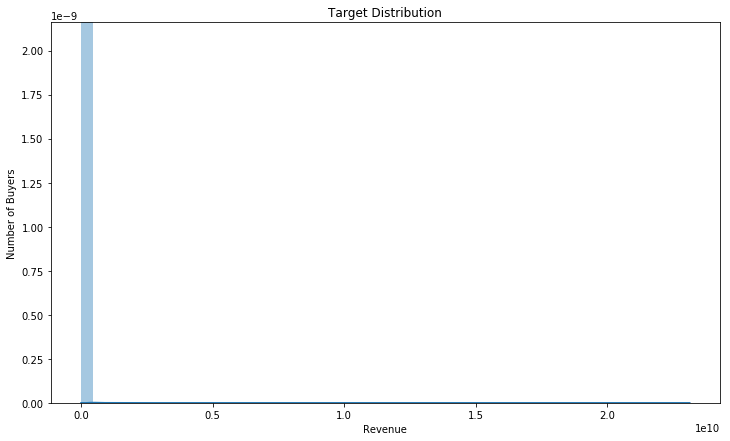

In [30]:
plt.figure(figsize=(12,7))
sns.distplot(train_df['totals.transactionRevenue']);
plt.xlabel("Revenue")
plt.ylabel("Number of Buyers")
plt.title("Target Distribution")

In [ ]:
plt.figure(figsize=(12,7))
tmp=np.log(train_df[train_df['totals.transactionRevenue'] > 0])
sns.distplot(tmp)
plt.xlabel("Revenue")
plt.ylabel("Number of Buyers")
plt.title("Target Distribution")

In [ ]:
Feature Engineering :
    I plotted a heatmap to see the correlation of transaction revenue with other data columns.

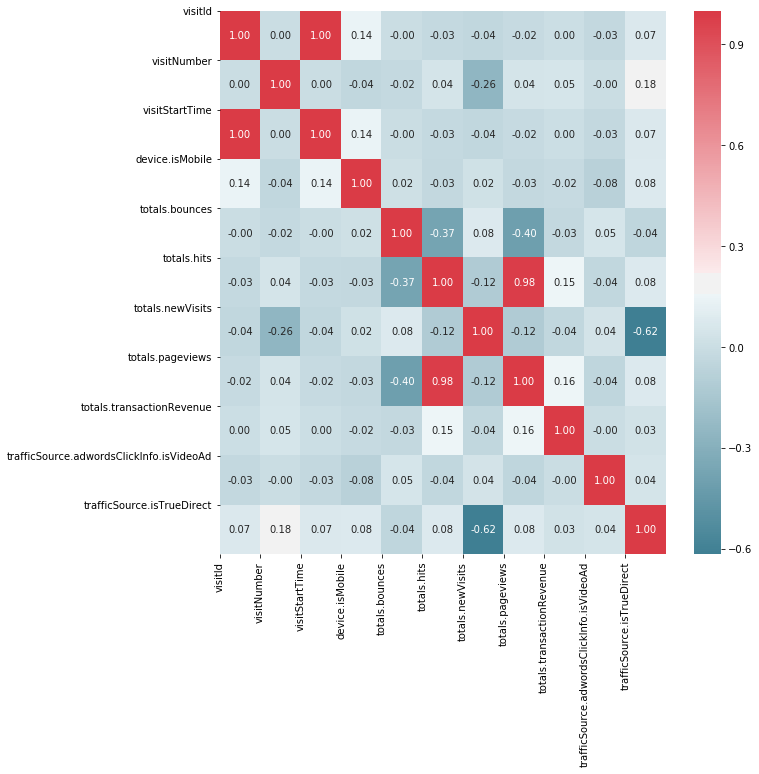

In [28]:
import seaborn as sns
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [ ]:
I saw a positive correlation between pageviews and hits, pageviews and transaction revenue and 
   transaction revenue and hits, so I plotted a graph to examine it better.

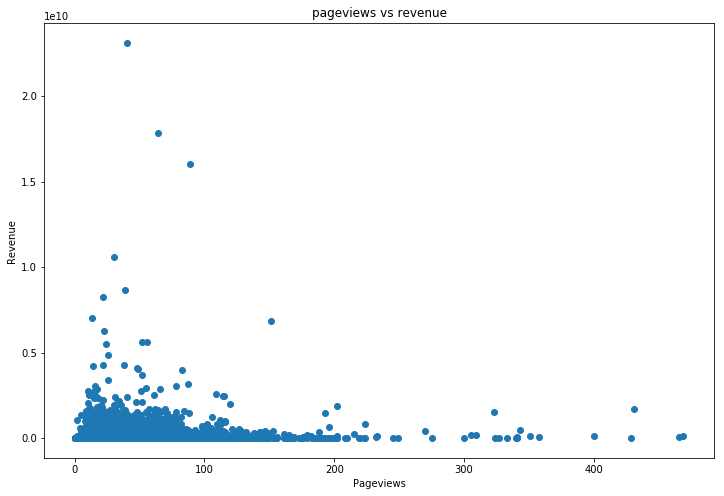

In [42]:
plt.figure(figsize=(8, 8))
plt.title('pageviews vs revenue');
plt.scatter(train_df['totals.pageviews'], train_df['totals.transactionRevenue']);
plt.xlabel('Pageviews');
plt.ylabel('Revenue');

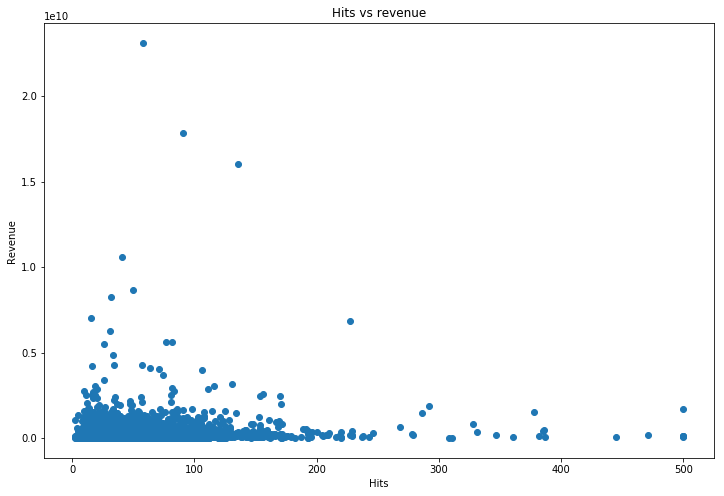

In [43]:
plt.figure(figsize=(8, 8))
plt.title('Hits vs revenue');
plt.scatter(train_df['totals.hits'], train_df['totals.transactionRevenue']);
plt.xlabel('Hits');
plt.ylabel('Revenue');

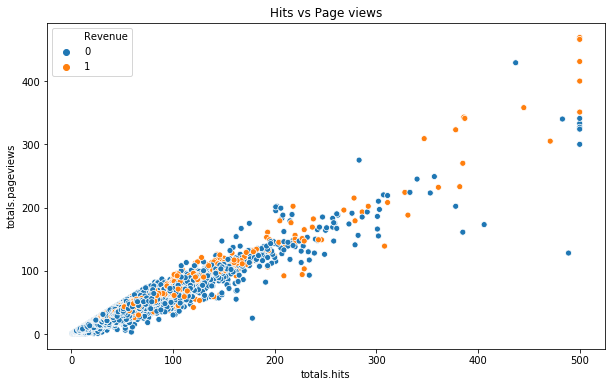

In [34]:
train_df['Revenue'] = train_df['totals.transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
plt.figure(figsize=(10,6))
plt.title("Hits vs Page views")
tmp = train_df[['totals.hits', 'totals.pageviews', 'Revenue']].copy()
ax = sns.scatterplot(x='totals.hits', y='totals.pageviews', hue='Revenue', data=tmp)

In [ ]:
Added a new columns in the dataframe for the log values of transaction revenue.

In [35]:
train_df['totals.transactionRevenue_log'] = np.log(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"] + 0.01)

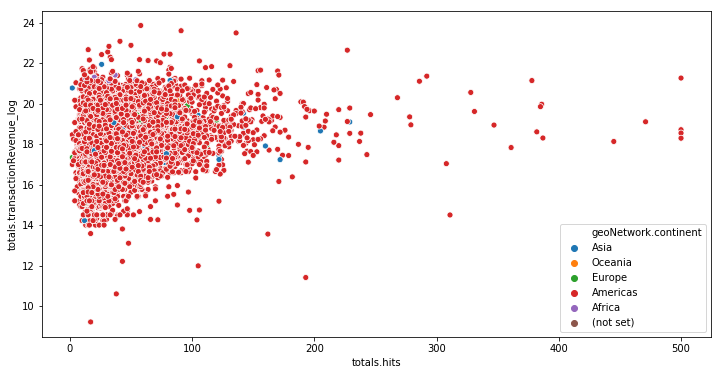

In [36]:
plt.figure(figsize=(12,6))
tmp = train_df[['totals.transactionRevenue_log', 'totals.hits','geoNetwork.continent']].copy()
ax = sns.scatterplot(x='totals.hits', y='totals.transactionRevenue_log', hue='geoNetwork.continent', data=tmp)

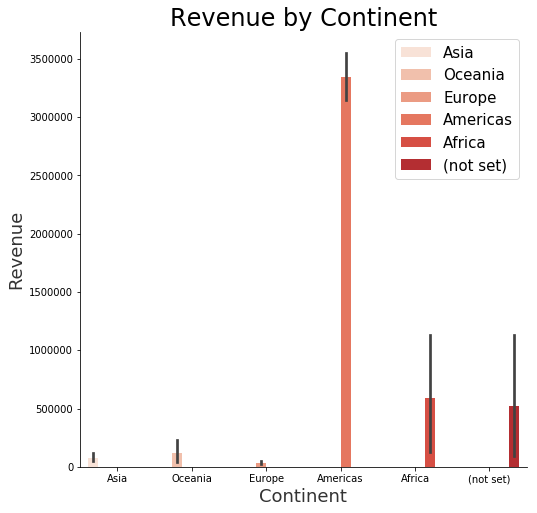

In [37]:
plt.figure(figsize=(8,8));
ax = sns.barplot(data=train_df, \
                 x='geoNetwork.continent', \
                 y='totals.transactionRevenue', \
                 hue='geoNetwork.continent', \
                 palette=sns.color_palette("Reds", n_colors=7, desat=1))

ax.set_xlabel("Continent", fontsize=18, alpha=0.8)
ax.set_ylabel("Revenue", fontsize=18, alpha=0.8)
ax.set_title("Revenue by Continent", fontsize=24)
ax.legend(fontsize=15)
sns.despine()
plt.show()

In [43]:
Plotted a graph to see the count of transactions by paying customer and non paying customer.

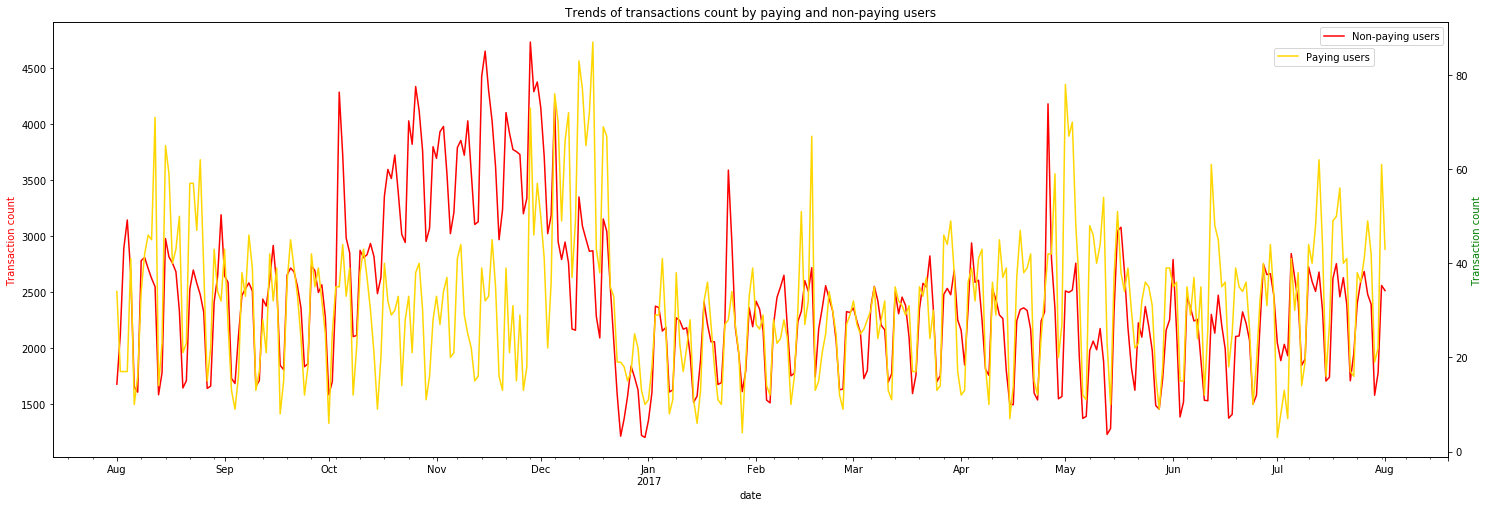

In [44]:
train_ = train_df.loc[train_df['totals.transactionRevenue'] <= 0.0]
fig, ax1 = plt.subplots(figsize=(25, 8))
plt.title("Trends of transactions count by paying and non-paying users");
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='red')
ax1.set_ylabel('Transaction count', color='r')
plt.legend(['Non-paying users'])
ax2 = ax1.twinx()
train_df.loc[train_df['totals.transactionRevenue'] > 0.0].groupby(['date'])['totals.transactionRevenue'].count().plot(color='gold')
ax2.set_ylabel('Transaction count', color='g')
plt.legend(['Paying users'], loc=(0.875, 0.9))
plt.grid(False)

In [ ]:
I plotted barcharts to see the count of the device and geography columns which gave me a rough idea
 as to which feature can contribute to the maximum revenue geneartion of GStore.

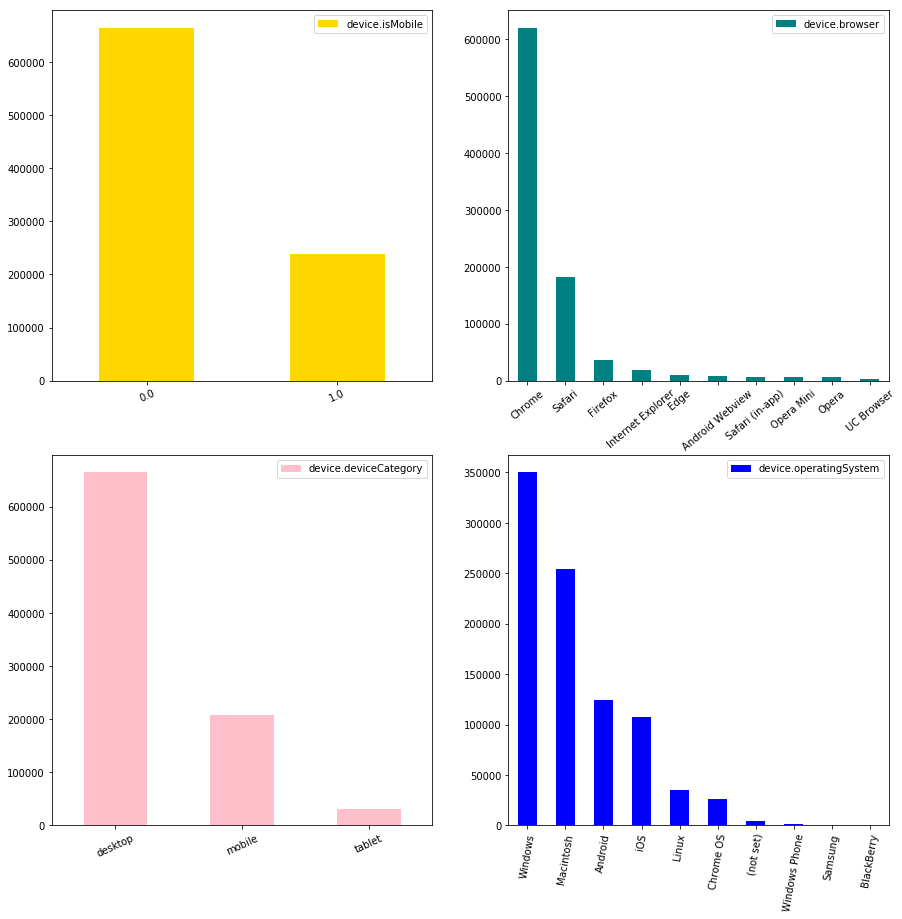

In [48]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
train_df["device.isMobile"].value_counts().plot(kind="bar",ax=axes[0][0],rot=25,legend="deviceisMobile",color='gold')
train_df["device.browser"].value_counts().head(10).plot(kind="bar",ax=axes[0][1],rot=40,legend="browser",color='teal')
train_df["device.deviceCategory"].value_counts().head(10).plot(kind="bar",ax=axes[1][0],rot=25,legend="deviceCategory",color='pink')
train_df["device.operatingSystem"].value_counts().head(10).plot(kind="bar",ax=axes[1][1],rot=80,legend="operatingSystem",color='blue')

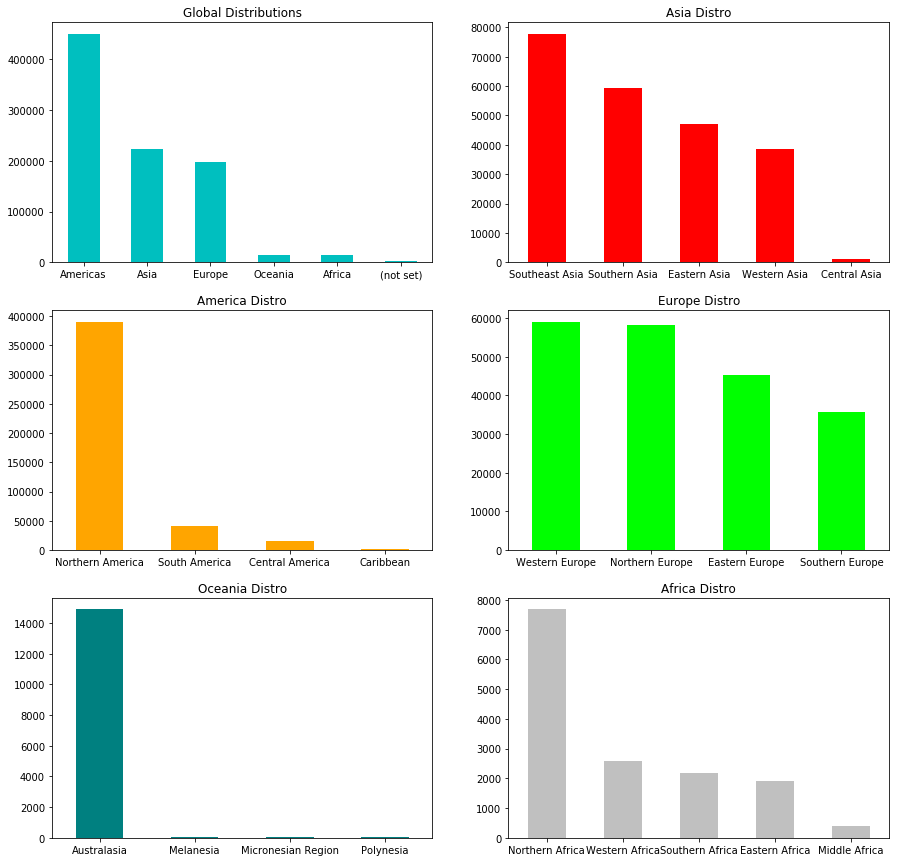

In [45]:
fig, axes = plt.subplots(3,2, figsize=(15,15))
train_df["geoNetwork.continent"].value_counts().plot(kind="bar",ax=axes[0][0],title="Global Distributions",rot=0,color="c")
train_df[train_df["geoNetwork.continent"] == "Americas"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][0], title="America Distro",rot=0,color="orange")
train_df[train_df["geoNetwork.continent"] == "Asia"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[0][1], title="Asia Distro",rot=0,color="r")
train_df[train_df["geoNetwork.continent"] == "Europe"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][1],  title="Europe Distro",rot=0,color="lime")
train_df[train_df["geoNetwork.continent"] == "Oceania"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax = axes[2][0], title="Oceania Distro",rot=0,color="teal")
train_df[train_df["geoNetwork.continent"] == "Africa"]["geoNetwork.subContinent"].value_counts().plot(kind="bar" , ax=axes[2][1], title="Africa Distro",rot=0,color="silver")

In [ ]:
mapped few data columns with transaction revenue to check the value which contributes most to 
  the revenue.

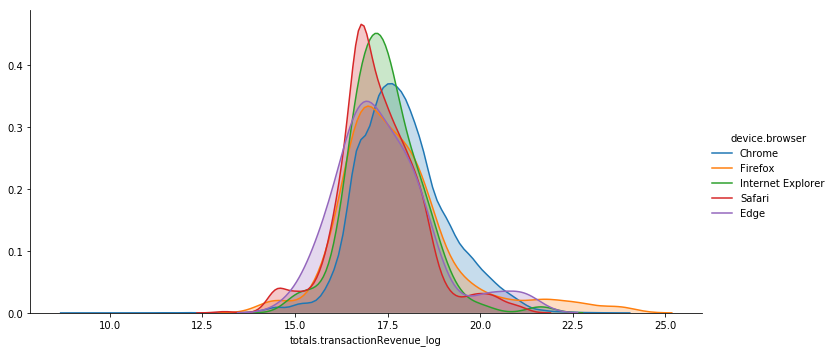

In [68]:
(sns.FacetGrid(train_df[train_df['device.browser'].isin(train_df['device.browser']\
                            .value_counts()[:5].index.values)],
               hue='device.browser', height=5, aspect=2)
  .map(sns.kdeplot, 'totals.transactionRevenue_log', shade=True)
 .add_legend()
)
plt.show()

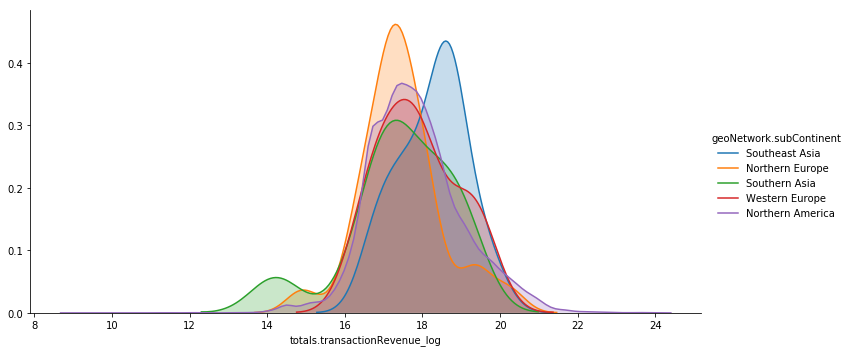

In [74]:
(sns.FacetGrid(train_df[train_df['geoNetwork.subContinent'].isin(train_df['geoNetwork.subContinent']\
                            .value_counts()[:5].index.values)],
               hue='geoNetwork.subContinent', height=5, aspect=2)
  .map(sns.kdeplot, 'totals.transactionRevenue_log', shade=True)
 .add_legend()
)
plt.show()

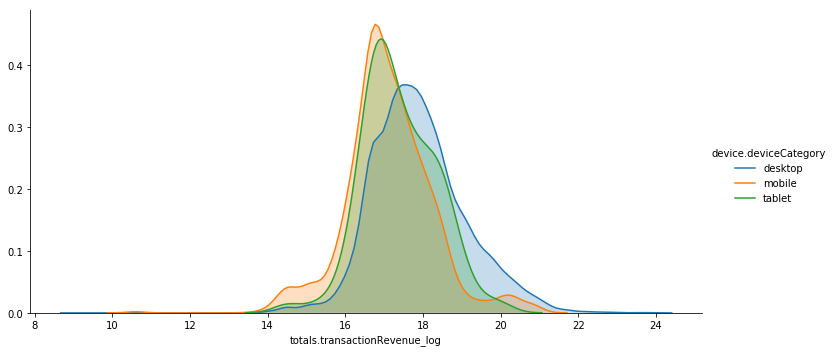

In [75]:
(sns.FacetGrid(train_df[train_df['device.deviceCategory'].isin(train_df['device.deviceCategory']\
                            .value_counts()[:5].index.values)],
               hue='device.deviceCategory', height=5, aspect=2)
  .map(sns.kdeplot, 'totals.transactionRevenue_log', shade=True)
 .add_legend()
)
plt.show()

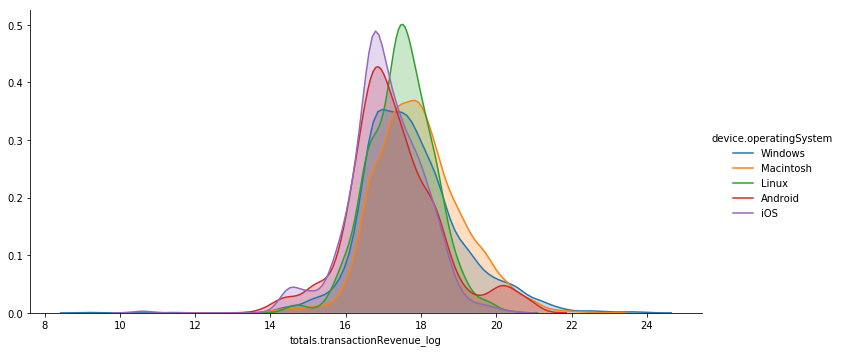

In [76]:
(sns.FacetGrid(train_df[train_df['device.operatingSystem'].isin(train_df['device.operatingSystem']\
                            .value_counts()[:5].index.values)],
               hue='device.operatingSystem', height=5, aspect=2)
  .map(sns.kdeplot, 'totals.transactionRevenue_log', shade=True)
 .add_legend()
)
plt.show()

In [ ]:
Logistic Regression to compute the top 10 buyers of the GStore.

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

x=train_df.drop(['totals.transactionRevenue'],axis=1)

x=x.drop(['totals.transactionRevenue_log'],axis=1)
x=x.drop(['trafficSource.adwordsClickInfo.page'],axis=1)
x=x.drop(['trafficSource.adwordsClickInfo.slot'],axis=1)
x=x.drop(['trafficSource.adwordsClickInfo.adNetworkType'],axis=1)
x=x.drop(['trafficSource.referralPath'],axis=1)
x=x.drop(['trafficSource.keyword'],axis=1)
x=x.drop(['trafficSource.adwordsClickInfo.gclId'],axis=1)
x=x.drop(['trafficSource.adContent'],axis=1)
x=x.apply(preprocessing.LabelEncoder().fit_transform)
y=train_df['totals.transactionRevenue'].copy()
y.loc[y==0]=0
y.loc[y>0]=1
lr=LogisticRegression()
lr.fit(x,y)

In [ ]:
lr=LogisticRegression()
lr.fit(x,y)

In [ ]:
predict_probs=lr.predict_proba(x)

In [ ]:
top_buyers=predict_probs[:,1].argsort()[::-1][:10]
print(top_buyers)

for i in top_buyers:
    print(data1.iloc[i]['fullVisitorId'])

In [44]:
train_df.drop(columns=['totals.transactionRevenue_log'], inplace=True)
train_df.drop(columns=['Revenue'], inplace=True)

In [ ]:
I have used the below model (LGBM) to predict the data.
I have taken help of Kaggle Kernel for this.

In [29]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [ ]:
y_reg = train_df['totals.transactionRevenue']
del train_df['totals.transactionRevenue']

In [40]:
for df in [train_df, test_df]:
    #df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

In [41]:
excluded_features = [
    'date','visitId', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitStartTime'
]

categorical_features = [
    _f for _f in train_df.columns
    if (_f not in excluded_features) & (train_df[_f].dtype == 'object')
]

In [42]:
for f in categorical_features:
    train_df[f], indexer = pd.factorize(train_df[f])
    test_df[f] = indexer.get_indexer(test_df[f])

In [45]:
folds = get_folds(df=train_df, n_splits=5)

train_features = [_f for _f in train_df.columns if _f not in excluded_features]
print(train_features)

pcand = 0
for i in range(25):
    train_df['totals.pageviews'] = np.random.permutation(train_df['totals.pageviews'])

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train_df.shape[0])
sub_reg_preds = np.zeros(test_df.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_df[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train_df[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test_df[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5
train_df['predictions'] = np.expm1(oof_reg_preds)
test_df['predictions'] = sub_reg_preds
trn_data = train_df[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()


# Create a list of predictions for each Visitor
trn_pred_list = train_df[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

sub_pred_list = test_df[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
sub_data = test_df[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape
train_df['target'] = y_reg
trn_user_target = train_df[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5


['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom', 'next_session_1', 'next_session_2', 'nb_pageviews', 'ratio_pageviews']
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid

C:\Users\Shreya Majumder\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log1p
C:\Users\Shreya Majumder\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log1p


Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.56021	TRAIN's rmse: 1.60006	VALID's l2: 2.67842	VALID's rmse: 1.63659
[200]	TRAIN's l2: 2.42559	TRAIN's rmse: 1.55743	VALID's l2: 2.62927	VALID's rmse: 1.6215
[300]	TRAIN's l2: 2.34683	TRAIN's rmse: 1.53194	VALID's l2: 2.61635	VALID's rmse: 1.61751
[400]	TRAIN's l2: 2.27873	TRAIN's rmse: 1.50955	VALID's l2: 2.61045	VALID's rmse: 1.61569
[500]	TRAIN's l2: 2.2167	TRAIN's rmse: 1.48886	VALID's l2: 2.60536	VALID's rmse: 1.61411
[600]	TRAIN's l2: 2.15887	TRAIN's rmse: 1.46931	VALID's l2: 2.60023	VALID's rmse: 1.61252
[700]	TRAIN's l2: 2.11063	TRAIN's rmse: 1.4528	VALID's l2: 2.59765	VALID's rmse: 1.61172
[800]	TRAIN's l2: 2.06519	TRAIN's rmse: 1.43708	VALID's l2: 2.59808	VALID's rmse: 1.61186
Early stopping, best iteration is:
[758]	TRAIN's l2: 2.08537	TRAIN's rmse: 1.44408	VALID's l2: 2.59631	VALID's rmse: 1.61131
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.56694	TRAIN's 

1.6154141005786329

In [46]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('new_test5.csv', index=True)

In [ ]:
Permutation test

In [34]:
from sklearn.utils import shuffle
import random
def perm_test (x,y):
    m=10000
    b=0
    
    true_corr=np.corrcoef(x,y)[0][1]
    for j in range(m):
        rs=random.randint(1, 1000)
        y_shuf = shuffle(y, random_state=rs)
        shuf_corr=np.corrcoef(x,y_shuf)[0][1]
        if (true_corr > 0):
            if (shuf_corr > true_corr):
                b=b+1
        else :
            if (shuf_corr < true_corr):
                    b=b+1
    
    return (b+1)/(m+1)

In [35]:
print (perm_test(train_df['totals.pageviews'], y_reg))

9.999000099990002e-05
